# Hourly Energy Consumption - Time Series Forcasting using LSTM and RNN 

# Time Series Forcasting using LSTM and RNN 

Time series forecasting predicts future values based on past data points collected over time. Key concerns include trends, seasonality, and randomness affecting patterns. Components involve:  
1. **Trend**: Long-term movement in the data.  
2. **Seasonality**: Repeating patterns at regular intervals.  
3. **Noise**: Random fluctuations.  
4. **Cyclic patterns**: Irregular, longer-term cycles.

#### Univariate and Multivariate

- A single variable measures over a period of time is called a univariate time series
- More than one dependent variabl

# Univariate Time Series Analysis

### Import libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

## Preparing Data

In [48]:
df = pd.read_csv(r"C:\Users\akash\OneDrive\Documents\DeepLearning\Time_serie_&Project\DOM_hourly_EnergyConsumption.csv")

In [49]:
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [39]:
df.tail()

,Datetime,DOM_MW
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0
116188,2018-01-02 00:00:00,17428.0


In [50]:
df.shape

(116189, 2)

In [46]:
df_daily = df[df['Datetime'].str.contains('00:00:00')]

In [47]:
df_daily.shape

(4841, 2)

In [51]:
df['Datetime'] =  pd.to_datetime(df.Datetime,format="%Y-%m-%d %H:%M:%S")
df.index = df.Datetime
df.drop({'Datetime'},axis=1,inplace=True)

In [52]:
df.index

DatetimeIndex(['2005-12-31 01:00:00', '2005-12-31 02:00:00',
               '2005-12-31 03:00:00', '2005-12-31 04:00:00',
               '2005-12-31 05:00:00', '2005-12-31 06:00:00',
               '2005-12-31 07:00:00', '2005-12-31 08:00:00',
               '2005-12-31 09:00:00', '2005-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=116189, freq=None)

In [53]:
#checking for missing vlaues
df.isnull().sum()

DOM_MW    0
dtype: int64

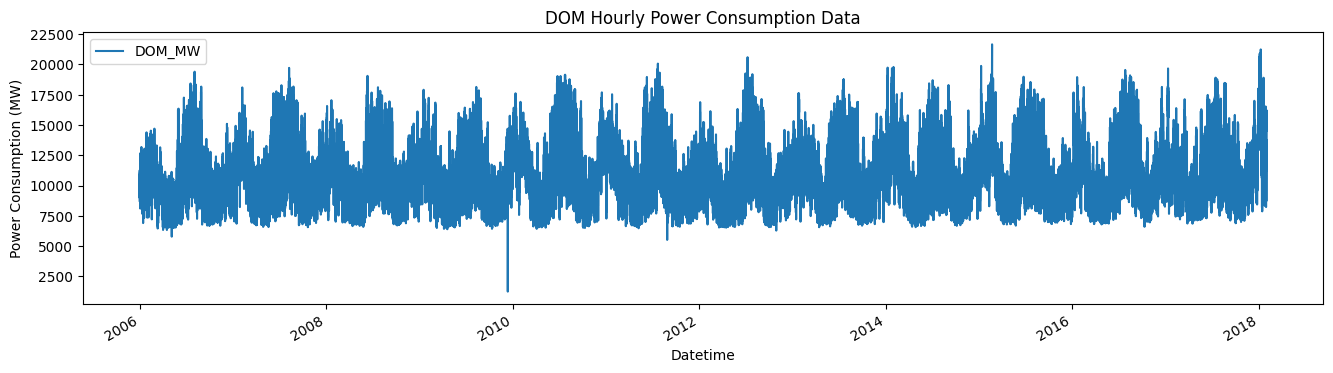

In [54]:
df = df.sort_index()

a = "2005-12-31 00:00:00"
b = '2018-01-31 00:00:00'

df.loc[a:b].plot(figsize=(16,4),legend=True)
plt.title('DOM Hourly Power Consumption Data')
plt.ylabel('Power Consumption (MW)')
plt.show()

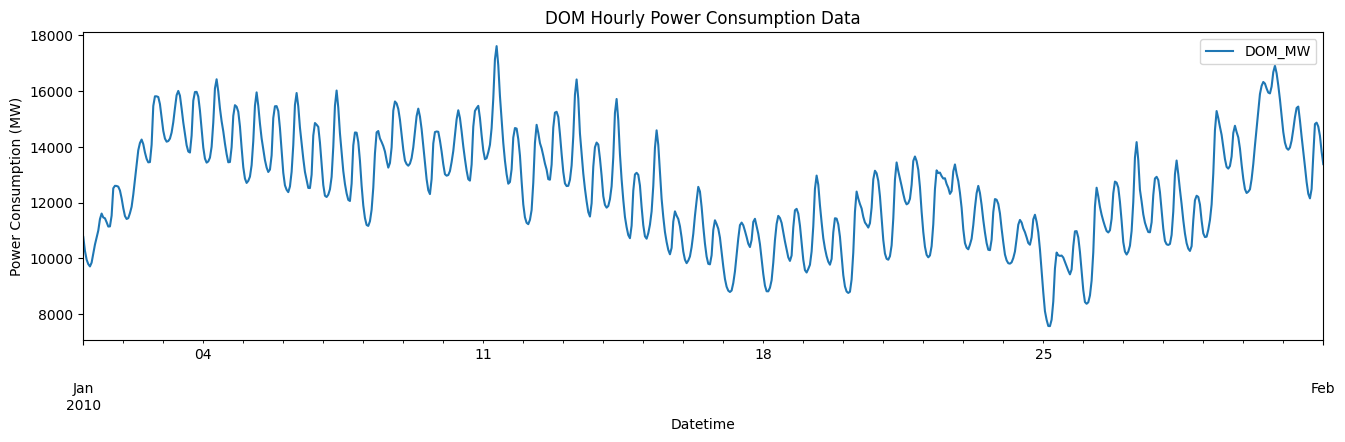

In [55]:
df = df.sort_index()

a = "2010-01-01 00:00:00"
b = '2010-02-01 00:00:00'

df.loc[a:b].plot(figsize=(16,4),legend=True)
plt.title('DOM Hourly Power Consumption Data')
plt.ylabel('Power Consumption (MW)')
plt.show()

### Normalizing data

In [56]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))

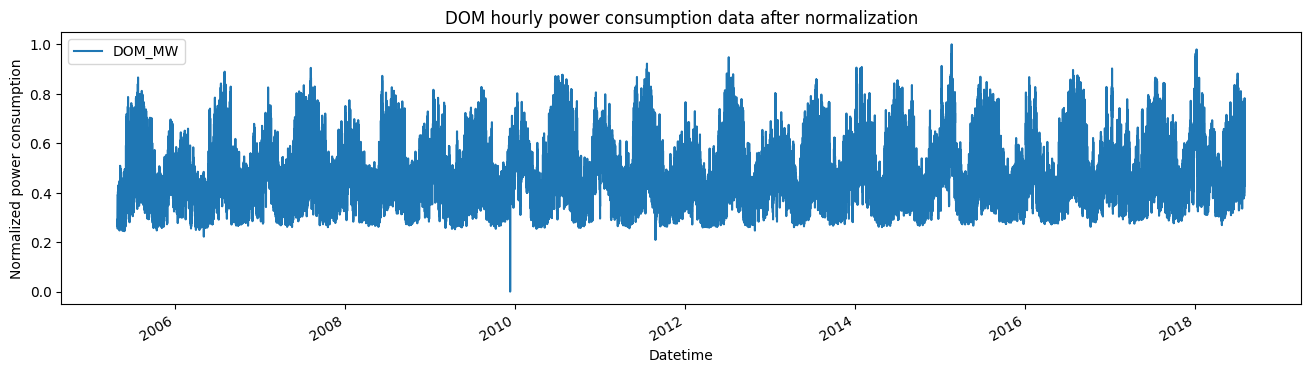

In [57]:
df.plot(figsize=(16,4),legend=True)
plt.title('DOM hourly power consumption data after normalization')
plt.ylabel('Normalized power consumption')
plt.show()

## Creating Training and Testing Data

In [58]:
def load_data(stock,seq_len):
    X_train = []
    y_train = []
    for i  in range(seq_len,len(stock)):
        X_train.append(stock.iloc[i-seq_len:i,0])
        y_train.append(stock.iloc[i,0])
    
    X_test = X_train[int(0.9*(len(stock))):]
    y_test = y_train[int(0.9*(len(stock))):]

    X_train = X_train[:int(0.9*(len(stock)))]
    y_train = y_train[:int(0.9*(len(stock)))]

    #converting into numpy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    #reshape into RNN
    X_train = np.reshape(X_train,(X_train.shape[0],seq_len,1))
    X_test = np.reshape(X_test,(X_test.shape[0],seq_len,1))

    return [X_train,y_train,X_test,y_test]
        

In [59]:
#create train and test data
seq_len = 20
X_train,y_train,X_test,y_test = load_data(df,seq_len)

In [60]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (104570, 20, 1)
y_train.shape =  (104570,)
X_test.shape =  (11599, 20, 1)
y_test.shape =  (11599,)


## Creating Input Tensors

In [61]:
batch_size = 256
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()

## Building the Model

In [63]:
rnn_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape =X_train.shape[-2:]),tf.keras.layers.Dense(1)])

In [64]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


## Compiling and Training

In [65]:
rnn_model.compile(optimizer = 'adam', loss = 'mae')

In [66]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
rnn_model.fit(train_data, epochs = EPOCHS,steps_per_epoch = EVALUATION_INTERVAL,validation_data = test_data,validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 8s 10ms/step - loss: 0.1295 - val_loss: 0.0764
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0673 - val_loss: 0.0643
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0580 - val_loss: 0.0555
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0483 - val_loss: 0.0439
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0357 - val_loss: 0.0320
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0271 - val_loss: 0.0226
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0209 - val_loss: 0.0165
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0161 - val_loss: 0.0133
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0127 - val_loss: 0.011

### Evaluation

In [67]:
rnn_predictions = rnn_model.predict(X_test)

363/363 [==============================] - 1s 3ms/step


In [68]:
rnn_Score = r2_score(y_test,rnn_predictions)
print(f'R2 score of RNN model: {rnn_Score}')

R2 score of RNN model: 0.984055889132709


## Actual vs predicted values

In [69]:
def plot_predictions(a,b,test,predicted,title):
    plt.figure(figsize=(16,4))
    plt.plot(test[a:b],color='blue',label='Normalized power consumption')
    plt.plot(predicted[a:b],alpha=0.7,color='orange',label='Predicted power consumption')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption')
    plt.legend()
    plt.show()

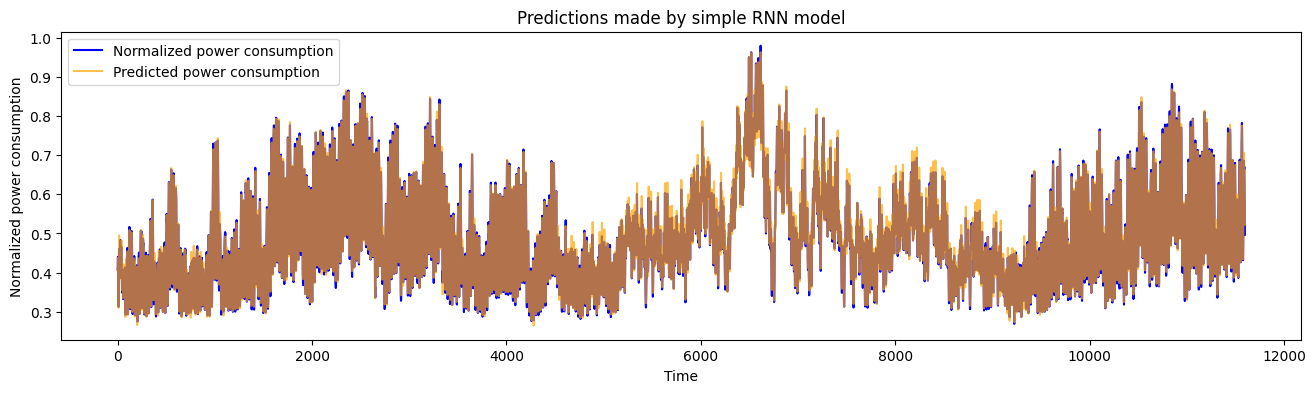

In [70]:
plot_predictions(0,12000,y_test,rnn_predictions,"Predictions made by simple RNN model")

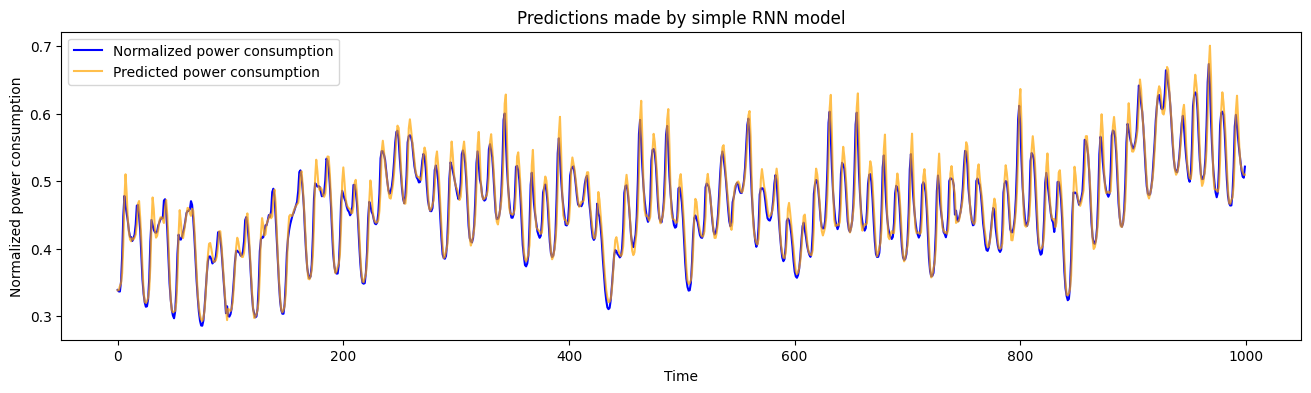

In [73]:
plot_predictions(5000,6000,y_test,rnn_predictions,"Predictions made by simple RNN model")

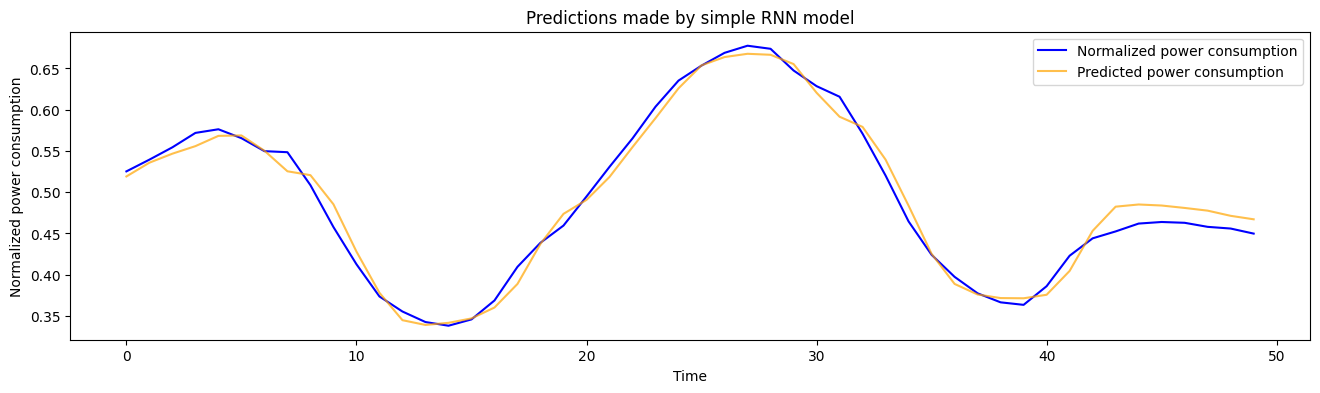

In [71]:
plot_predictions(3500,3550,y_test,rnn_predictions,"Predictions made by simple RNN model")

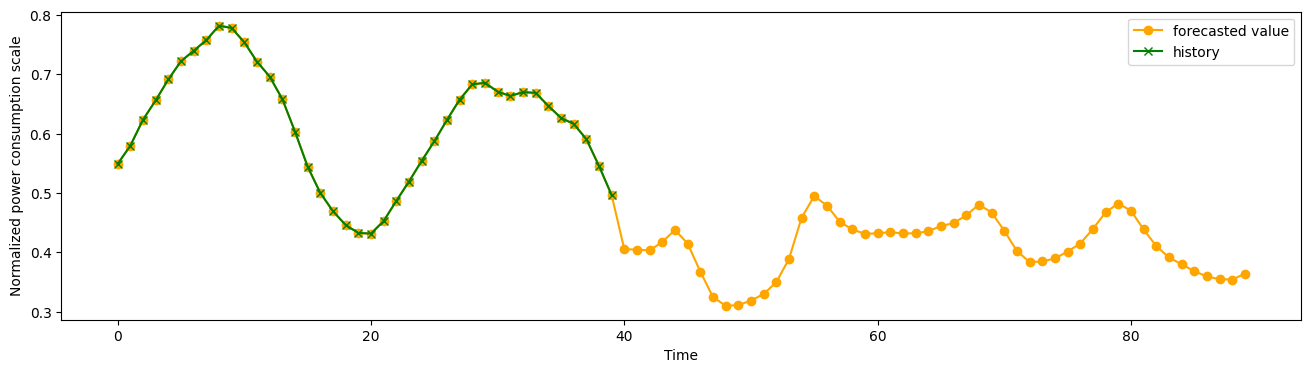

In [74]:
history_data = list(y_test[-40:])
flattened_predictions = [pred[0] for pred in rnn_predictions[:50]]
plottingvalues = list(history_data)+flattened_predictions
plt.figure(figsize = (16,4))
plt.plot(plottingvalues, color = 'orange',label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',label = 'history',marker = 'x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

## Predicting Next Data

In [75]:
X  =X_test[-1:]
rnn_predictions1 = rnn_model.predict(X)

1/1 [==============================] - 0s 26ms/step


In [76]:
rnn_predictions1

array([[0.52288616]], dtype=float32)

In [77]:
X_test

array([[[0.43053241],
        [0.38699873],
        [0.34748505],
        ...,
        [0.40356898],
        [0.40479459],
        [0.40680459]],

       [[0.38699873],
        [0.34748505],
        [0.31856064],
        ...,
        [0.40479459],
        [0.40680459],
        [0.4080302 ]],

       [[0.34748505],
        [0.31856064],
        [0.30331405],
        ...,
        [0.40680459],
        [0.4080302 ],
        [0.40930483]],

       ...,

       [[0.46950681],
        [0.44612217],
        [0.43283655],
        ...,
        [0.64712227],
        [0.62677714],
        [0.61667811]],

       [[0.44612217],
        [0.43283655],
        [0.43165997],
        ...,
        [0.62677714],
        [0.61667811],
        [0.59118541]],

       [[0.43283655],
        [0.43165997],
        [0.45283851],
        ...,
        [0.61667811],
        [0.59118541],
        [0.5459849 ]]])

In [78]:
X  =X_test[-1]
X.shape

(20, 1)

In [79]:
rnn_predictions1

array([[0.52288616]], dtype=float32)

In [80]:
df.head()

,DOM_MW
Datetime,
2005-05-01 01:00:00,0.291058
2005-05-01 02:00:00,0.272085
2005-05-01 03:00:00,0.261300
2005-05-01 04:00:00,0.254878
2005-05-01 05:00:00,0.254535


In [81]:
df.tail()

,DOM_MW
Datetime,
2018-08-02 20:00:00,0.626777
2018-08-02 21:00:00,0.616678
2018-08-02 22:00:00,0.591185
2018-08-02 23:00:00,0.545985
2018-08-03 00:00:00,0.496715


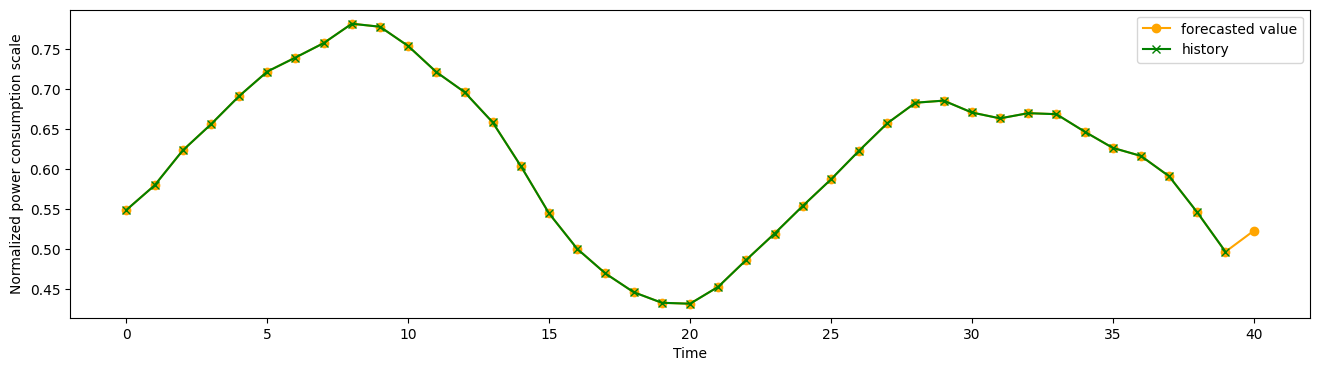

In [82]:
history_data = list(y_test[-40:])
flattened_predictions = [pred[0] for pred in rnn_predictions1[:50]]
plottingvalues = list(history_data)+flattened_predictions
plt.figure(figsize = (16,4))
plt.plot(plottingvalues, color = 'orange',
label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',
label = 'history',marker = 'x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [83]:
hostory_data = list(y_test[-40:])

def make_data(X,rnn_predictions1):
    val = list(X[0][1:])+list(rnn_predictions1)
    X_new = []
    X_new.append(list(val))
    X_new = np.array(X_new)
    return X_new

In [84]:
forecast = list()
X = X_test[-1:]


for i in range (25):
    X = make_data(X,rnn_predictions1)
    rnn_predictions1 = rnn_model.predict(X)
    forecast += list(rnn_predictions1)

1/1 [==============================] - 0s 28ms/step


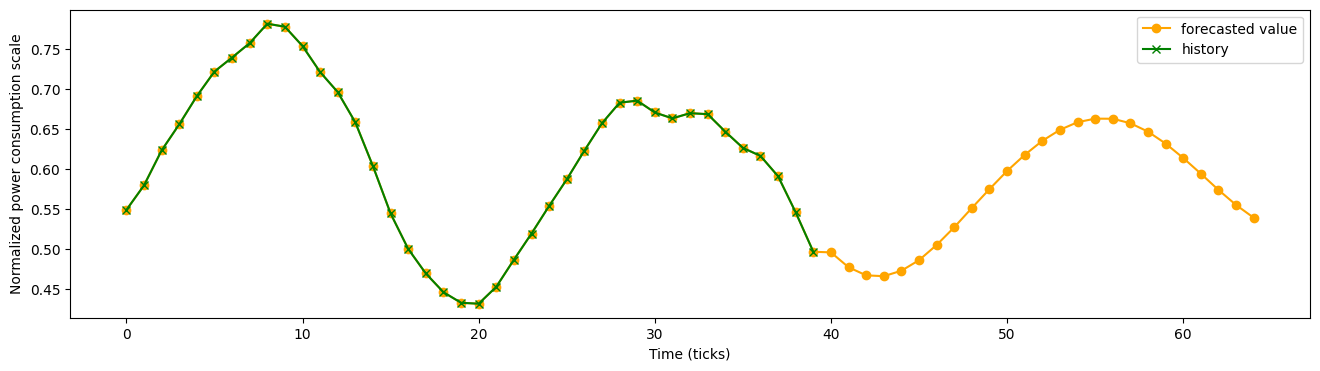

In [85]:
flattened_forecast = [val[0] if isinstance(val, (np.ndarray, list)) else val for val in forecast]

# Combine history_data and flattened_forecast
plottingvalues = list(history_data) + flattened_forecast

# Plotting
plt.figure(figsize=(16, 4))
plt.plot(plottingvalues, color='orange', label='forecasted value', marker='o')
plt.plot(list(y_test[-40:]), color='green', label='history', marker='x')
plt.xlabel('Time (ticks)')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [ ]:
Here We predicted next 25 data points